In [1]:
import pickle
import numpy as np

x_train, y_train = pickle.load(open('../outputs/train_xy_no_sampling_stdScale.pk', 'rb'))
x_cv, y_cv = pickle.load(open('../outputs/val_xy_no_sampling_stdScale.pk', 'rb'))
x_test, y_test = pickle.load(open('../outputs/test_xy_no_sampling_stdScale.pk', 'rb'))
print('shapes of train, validation, test data', x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape)
values, counts = np.unique(y_train, return_counts=True)
print('Frequency of distance values before sampling', values, counts)

shapes of train, validation, test data (569388, 128) (569388,) (142347, 128) (142347,) (237245, 128) (237245,)
Frequency of distance values before sampling [1 2 3 4 5 6 7] [  6105 189469 307090  60097   6098    507     22]


In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, TomekLinks, RandomUnderSampler
from imblearn.over_sampling import KMeansSMOTE, SMOTE

seed_random = 9999
# max_idx = np.argmax(counts)
# max_value = counts[max_idx]
# majority_class = values[max_idx]

x = int(counts[2]*0.7)
y = int(0.7 * x)

undersample_dict = {2:y, 3:x}
under_sampler = RandomUnderSampler(sampling_strategy=undersample_dict, random_state=seed_random)  #  n_jobs=15,
x_train, y_train = under_sampler.fit_resample(x_train, y_train.astype(np.int))
print('Frequency of distance values after undersampling', np.unique(y_train, return_counts=True))

minority_samples = int(0.7*x)
oversample_dict = {1:minority_samples, 4:minority_samples, 5:minority_samples, 6:minority_samples, 7:minority_samples}
over_sampler = RandomOverSampler(sampling_strategy=oversample_dict, random_state=seed_random)  # ,n_jobs=15, k_neighbors= 5
x_train, y_train = over_sampler.fit_resample(x_train, y_train.astype(np.int))
print('Frequency of distance values after oversampling', np.unique(y_train, return_counts=True))

pickle.dump((x_train, y_train), open('../outputs/train_xy_combine_sampling.pk', 'wb'))

x_train.shape, y_train.shape

Frequency of distance values after undersampling (array([1, 2, 3, 4, 5, 6, 7]), array([  6105, 150474, 214963,  60097,   6098,    507,     22],
      dtype=int64))
Frequency of distance values after oversampling (array([1, 2, 3, 4, 5, 6, 7]), array([150474, 150474, 214963, 150474, 150474, 150474, 150474],
      dtype=int64))


((1117807, 128), (1117807,))

In [23]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0, 1))
# y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
# y_cv = scaler.transform(y_cv.reshape(-1, 1)).flatten()
# y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

In [3]:
from utils import *
import numpy as np

np.random.seed(999)
x_train, y_train = unison_shuffle_copies(x_train, y_train)

#### Creating a baseline for this dataset by training a Linear Regression model.

In [44]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1).fit(x_train, y_train)

In [60]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

y_pred = baseline_model.predict(x_test)
y_class = np.round(y_pred)
baseline_acc = accuracy_score(y_test, y_class)*100
baseline_mse = mean_squared_error(y_test, y_pred)
baseline_mae = mean_absolute_error(y_test, y_pred)
print("Baseline: Accuracy={}%, MSE={}, MAE={}".format(round(baseline_acc, 2), round(baseline_mse,2), round(baseline_mae,2)))

Baseline: Accuracy=50.57%, MSE=0.56, MAE=0.59


This concludes setting the baseline for this problem. We wil compare our neural network results with this to see how much we have improved.

In [54]:
y_class == y_test

False

In [30]:
params =  {'batch_size': 2000, 'input_size': 128, 'hidden_units_1': 256, 'hidden_units_2': 100, 'hidden_units_3': 50, 'do_1': 0.15, 'do_2': 0.25, 'output_size': 1, 'lr': 0.001, 'min_lr': 1e-4, 'max_lr': 1e-1, 'epochs': 500, 'lr_sched_mode': 'triangular2', 'gamma': 0.99994}
# 0.00012 to 0.0002
# 1e-4 to 1e-2
params

{'batch_size': 2000,
 'input_size': 128,
 'hidden_units_1': 256,
 'hidden_units_2': 100,
 'hidden_units_3': 50,
 'do_1': 0.15,
 'do_2': 0.25,
 'output_size': 1,
 'lr': 0.001,
 'min_lr': 0.0001,
 'max_lr': 0.1,
 'epochs': 500,
 'lr_sched_mode': 'triangular2',
 'gamma': 0.99994}

In [31]:
import torch
from torch.utils import data as torch_data

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

trainset = torch_data.TensorDataset(torch.as_tensor(x_train, dtype=torch.float, device=device), torch.as_tensor(y_train, dtype=torch.float, device=device))
train_dl = torch_data.DataLoader(trainset, batch_size=params['batch_size'], drop_last=True)

val_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_cv, dtype=torch.float, device=device), torch.as_tensor(y_cv, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

test_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_test, dtype=torch.float, device=device), torch.as_tensor(y_test, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

device: cuda:0


In [32]:
print('value counts in whole data', np.unique(y_train, return_counts=True))
count = 0
for i, data in enumerate(train_dl, 0):
    input, target = data[0], data[1]
    t = torch.unique(target, return_counts=True)[1]
    if (t==params['batch_size']).any().item():
        count += 1
print('{} ({}%) batches have all same targets'.format(count, np.round(count/len(train_dl)*100, 2) ))

value counts in whole data (array([1, 2, 3, 4, 5, 6, 7]), array([150474, 150474, 214963, 150474, 150474, 150474, 150474],
      dtype=int64))
0 (0.0%) batches have all same targets


In [34]:
from torchsummary import summary

torch.manual_seed(9999)
def get_model():
    model = torch.nn.Sequential(
        torch.nn.Linear(params['input_size'], params['hidden_units_1']),
        torch.nn.BatchNorm1d(params['hidden_units_1']),
        torch.nn.Dropout(p=params['do_1']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_1'], params['hidden_units_2']),
        torch.nn.BatchNorm1d(params['hidden_units_2']),
        torch.nn.Dropout(p=params['do_2']),
        torch.nn.ReLU(),
        # torch.nn.Linear(params['hidden_units_2'], params['hidden_units_3']),
        # # torch.nn.Dropout(p=0.04),
        # torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_2'], params['output_size']),
        torch.nn.ReLU(),
        # torch.nn.Softplus(),
    )
    model.to(device)
    return model

def poisson_loss(y_pred, y_true):
    """
    Custom loss function for Poisson model.
    Equivalent Keras implementation for reference:
    K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)
    For output of shape (2,3) it return (2,) vector. Need to calculate
    mean of that too.
    """
    y_pred = torch.squeeze(y_pred)
    loss = torch.mean(y_pred - y_true * torch.log(y_pred+1e-7))
    return loss

model = get_model()

print('model loaded into device=', next(model.parameters()).device)
summary(model, input_size=(128, ))

lr_reduce_patience = 20
lr_reduce_factor = 0.1

# loss_fn = torch.nn.MSELoss(reduction='mean')
# loss_fn = torch.nn.L1Loss(reduction='mean')
loss_fn = poisson_loss
# optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'], momentum=0.9, dampening=0, weight_decay=0, nesterov=True)
optimizer = torch.optim.RMSprop(model.parameters(), lr=params['lr'], alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_reduce_factor, patience=lr_reduce_patience, verbose=True, threshold=0.00001, threshold_mode='rel', cooldown=0, min_lr=1e-9, eps=1e-08)
# lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=params['max_lr'], steps_per_epoch=len(train_dl), epochs=params['epochs'], div_factor=1e3)
lr_sched = torch.optim.lr_scheduler.CyclicLR(optimizer, params['min_lr'], params['max_lr'], step_size_up=8*len(train_dl), step_size_down=None, mode=params['lr_sched_mode'], last_epoch=-1, gamma=params['gamma'])  # 1e-6, 1e-2, 4or8*len(train_dl), scale_mode=req for custom scale, last_epoch= num_of_iters_calculated--pass prev train iters if resuming 
for param_group in optimizer.param_groups:
    print(param_group['lr'])

model loaded into device= cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          33,024
       BatchNorm1d-2                  [-1, 256]             512
           Dropout-3                  [-1, 256]               0
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 100]          25,700
       BatchNorm1d-6                  [-1, 100]             200
           Dropout-7                  [-1, 100]               0
              ReLU-8                  [-1, 100]               0
            Linear-9                    [-1, 1]             101
             ReLU-10                    [-1, 1]               0
Total params: 59,537
Trainable params: 59,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Par

#### Run next cell to find optimal range for learning rate while using One-Cycle LR scheduler
In this case choosing the learning rate from graph below didn't help (same training speed as previoius range). Why?

#### from https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

import math

lr_arr = np.zeros((len(train_dl), ))

def find_lr(init_value = 1e-5, final_value=0.1, beta = 0.98):
    global lr_arr
    num = len(train_dl)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    lrs = []
    for data in train_dl:
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs, labels = data
        # inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        # print('appending lr={}'.format(lr))
        lrs.append(lr)
        lr_arr[batch_num-1] = lr
        # print('appended lr={}'.format(lrs[-1], lr_arr[]))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        # print('{}*{}'.format(lr, mult), end="")
        lr *= mult
        # print('={}'.format(lr))
        optimizer.param_groups[0]['lr'] = lr
        #if batch_num % 10 == 0:
        # print('batch_num:', batch_num, 'lr=', lr, 'smoothed_loss=', smoothed_loss, 'best_loss=', best_loss)
    return log_lrs, losses

lrs, losses = find_lr()
print('returned', len(losses))
plt.figure()
plt.plot(lr_arr[:len(lrs)], losses)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#### plt.xticks(np.arange(min(lrs), max(lrs), 0.0001))
plt.title('LR range plot')
plt.xlabel('Learning rates')
plt.ylabel('Losses')
plt.show()

In [35]:
def evaluate(model, dl):
    model.eval()
    final_loss = 0.0
    count = 0
    with torch.no_grad():
        for data_cv in dl:
            inputs, dist_true = data_cv[0], data_cv[1]
            count += len(inputs)
            outputs = model(inputs)
            loss = loss_fn(outputs, dist_true)
            final_loss += loss.item()
    return final_loss/len(dl)

def save_checkpoint(state, state_save_path):
    if not os.path.exists("/".join(state_save_path.split('/')[:-1])):
        os.makedirs("/".join(state_save_path.split('/')[:-1]))
    torch.save(state, state_save_path)

In [36]:
%%time
# %load_ext tensorboard

import time
import copy
from tqdm.auto import tqdm
from utils import *
from torch.utils.tensorboard import SummaryWriter
# from tensorboardX import SummaryWriter

last_loss = 0.0
min_val_loss = np.inf
patience_counter = 0
early_stop_patience = 50
best_model = None
train_losses = []
val_losses = []

output_path = '../outputs'
tb_path = output_path+'/logs/runs'
run_path = tb_path+'/run28_maxLr_batchSize_trng2'
checkpoint_path = run_path+'/checkpoints'
resume_training = False
start_epoch = 0
iter_count = 0

if os.path.exists(run_path):
    raise Exception("this experiment already exists!")

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

writer = SummaryWriter(log_dir=run_path, comment='', purge_step=None, max_queue=1, flush_secs=30, filename_suffix='')

# resume training on a saved model
if resume_training:
    prev_checkpoint_path = '../outputs/logs/runs/run17_std_scale_more_data/checkpoints'  # change this
    suffix = 'cp'  # change this
    model.load_state_dict(torch.load(prev_checkpoint_path+'/model_'+suffix+'.pt'))
    optimizer.load_state_dict(torch.load(prev_checkpoint_path+'/optim_'+suffix+'.pt'))
    lr_sched.load_state_dict(torch.load(prev_checkpoint_path+'/sched_'+suffix+'.pt'))
    state = torch.load(prev_checkpoint_path+'/state_'+suffix+'.pt') 
    start_epoch = state['epoch']
    writer.add_text('loaded saved model:', str(params))
    print('loaded saved model', params)

writer.add_text('run_change', 'same as run 20 but with larger batch_size(for better batchNorm), larger max_lr' + str(params))

torch.backends.cudnn.benchmark = True
print('total epochs=', len(range(start_epoch, start_epoch+params['epochs'])))
# epoch_bar = tqdm(range(epochs), ncols=12000)  # tqdm really slows down training! 
# with torch.autograd.detect_anomaly():
for param_group in optimizer.param_groups:
    print('lr-check', param_group['lr'])
for epoch in range(start_epoch, start_epoch+params['epochs']):  # loop over the dataset multiple times
    running_loss = 0.0
    stime = time.time()
    
    for i, data in enumerate(train_dl, 0):
        iter_count += 1
        # get the inputs; data is a list of [inputs, dist_true]
        model.train()
        inputs, dist_true = data[0], data[1]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, dist_true)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        last_loss = loss.item()

        for param_group in optimizer.param_groups:
            curr_lr = param_group['lr']
        writer.add_scalar('monitor/lr-iter', curr_lr, iter_count-1)

        if not isinstance(lr_sched, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_sched.step()

    val_loss = evaluate(model, val_dl)
    if isinstance(lr_sched, torch.optim.lr_scheduler.ReduceLROnPlateau):
        lr_sched.step(val_loss)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
        best_model = copy.deepcopy(model)
        print(epoch,"> Best val_loss model saved:", round(val_loss, 4))
    else:
        patience_counter += 1
    train_loss = running_loss/len(train_dl)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    writer.add_scalar('loss/train', train_loss, epoch)
    writer.add_scalar('loss/val', val_loss, epoch)
    for param_group in optimizer.param_groups:
        curr_lr = param_group['lr']
    writer.add_scalar('monitor/lr-epoch', curr_lr, epoch)
    if patience_counter > early_stop_patience:
        print("Early stopping at epoch {}. current val_loss {}".format(epoch, val_loss))
        break

    if epoch % 10 == 0:
        torch.save(best_model.state_dict(), checkpoint_path+'/model_cp.pt')
        torch.save(optimizer.state_dict(), checkpoint_path+'/optim_cp.pt')
        torch.save(lr_sched.state_dict(), checkpoint_path+'/sched_cp.pt')
        writer.add_text('checkpoint saved', 'at epoch='+str(epoch))
        print("epoch:{} -> train_loss={},val_loss={} - {}".format(epoch, round(train_loss, 5),                round(val_loss, 5), seconds_to_minutes(time.time()-stime)))
    # epoch_bar.update(1)
    # epoch_bar.set_description(desc="train_loss={},val_loss={},running_loss={}".format(round(last_loss,3), round(val_loss,3), running_loss))

print('Finished Training')
ts = str(time.time())
best_model_path = checkpoint_path+'/model_'+ts+'.pt'
opt_save_path = checkpoint_path+'/optim_'+ts+'.pt'
sched_save_path = checkpoint_path+'/sched_'+ts+'.pt'
state_save_path = checkpoint_path+'/state_'+ts+'.pt'
state = {'epoch': epoch+1,
        'model_state': model.state_dict(),
        'optim_state': optimizer.state_dict(),
        'last_train_loss': train_losses[-1],
        'last_val_loss': val_losses[-1],
        'total_iters': iter_count
        }

save_checkpoint(state, state_save_path)
# sometimes loading from state dict is not wokring, so...
torch.save(best_model.state_dict(), best_model_path)
torch.save(optimizer.state_dict(), opt_save_path)
torch.save(lr_sched.state_dict(), sched_save_path)

# run 16 had min/max lr swapped by mistake, try again
# Top runs: run21, run20, run19_batch_norm_other_changes, run18_trngl2, run10_3

total epochs= 500
lr-check 0.0001
0 > Best val_loss model saved: -0.093
epoch:0 -> train_loss=-1.59835,val_loss=-0.09297 - 0.0 minutes 37.0 seconds
2 > Best val_loss model saved: -0.0934
3 > Best val_loss model saved: -0.0971
4 > Best val_loss model saved: -0.1017
8 > Best val_loss model saved: -0.1044
10 > Best val_loss model saved: -0.1049
epoch:10 -> train_loss=-1.83238,val_loss=-0.10487 - 0.0 minutes 37.0 seconds
13 > Best val_loss model saved: -0.1081
epoch:20 -> train_loss=-1.86652,val_loss=-0.10758 - 0.0 minutes 36.0 seconds
24 > Best val_loss model saved: -0.1092
epoch:30 -> train_loss=-1.86997,val_loss=-0.10749 - 0.0 minutes 37.0 seconds
epoch:40 -> train_loss=-1.8687,val_loss=-0.10838 - 0.0 minutes 37.0 seconds
epoch:50 -> train_loss=-1.8709,val_loss=-0.10771 - 0.0 minutes 38.0 seconds
57 > Best val_loss model saved: -0.11
epoch:60 -> train_loss=-1.87105,val_loss=-0.10794 - 0.0 minutes 35.0 seconds
epoch:70 -> train_loss=-1.87093,val_loss=-0.10892 - 0.0 minutes 35.0 seconds
e

In [41]:
writer.add_text('ending_remark', 'bad result.. distance 2 has good accuracy but 1,6,7 are really bad.')

In [39]:
def test(model, dl):
    model.eval()
    final_loss = 0.0
    count = 0
    y_hat = []
    with torch.no_grad():
        for data_cv in dl:
            inputs, dist_true = data_cv[0], data_cv[1]
            count += len(inputs)
            outputs = model(inputs)
            y_hat.extend(outputs.tolist())
            loss = loss_fn(outputs, dist_true)
            final_loss += loss.item()
    return final_loss/len(dl), y_hat

# best_model_path = 'C:/Users/nayak/Documents/Projects/ml_projects/shortest-distance-approx-deep-learning/outputs/logs/runs/run17_std_scale_more_data/checkpoints/model_cp.pt'
model.load_state_dict(torch.load(best_model_path)) 
test_loss, y_hat = test(model, test_dl)
print(test_loss)
try:
    if scaler:
        y_hat = scaler.inverse_transform(y_hat)
        y_test = scaler.inverse_transform(y_test)
except:
    pass
y_hat[50:60], y_test[50:60]

-0.11034704801642288


([[3.3530514240264893],
  [4.343031406402588],
  [2.7575807571411133],
  [3.675015449523926],
  [2.7733190059661865],
  [2.7161192893981934],
  [2.4442341327667236],
  [2.269906520843506],
  [3.544426918029785],
  [2.9102840423583984]],
 array([3, 4, 3, 4, 3, 2, 3, 3, 4, 3]))

237245 236000


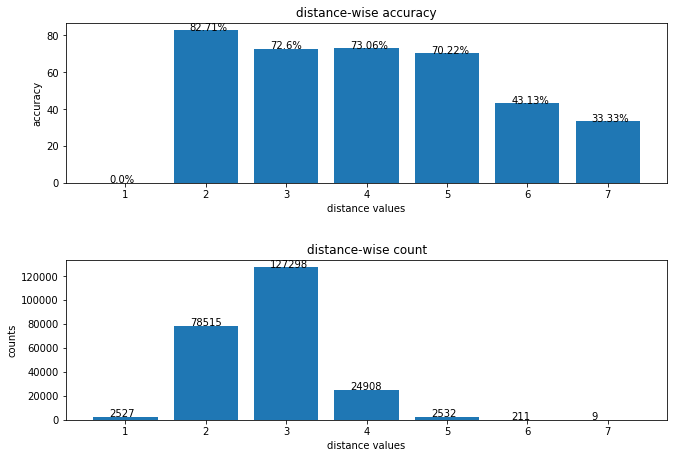

class avg accuracy 53.579319111880196
MSE 0.184495268614979
MAE 0.34365128815477175


In [40]:
# show distance value wise precision (bar chart)
# predicted values are less that real test samples because last samples from test are dropped # to maintain save batch size (drop_last=True)
from matplotlib import pyplot as plt

y_hat_ = np.array(y_hat).squeeze()
y_test_ = y_test[:len(y_hat)]
print(len(y_test), len(y_hat))
dist_accuracies = []
dist_counts = [] 
for i in range(1, 8):
    mask = y_test_==i
    dist_values = y_test_[mask]
    dist_preds = np.round(y_hat_[mask])
    # print(len(mask), len(dist_values), len(dist_preds))
    # print(i, np.sum(np.equal(dist_values, dist_preds)), len(dist_values))
    dist_accuracies.append(np.sum(dist_values == dist_preds)*100/len(dist_values))
    dist_counts.append(len(dist_values))

fig = plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.bar(range(1,8), dist_accuracies)
for index, value in enumerate(dist_accuracies):
    plt.text(index+0.8, value, str(np.round(value, 2))+'%')
plt.title('distance-wise accuracy')
plt.xlabel('distance values')
plt.ylabel('accuracy')
plt.subplot(2,1,2)
plt.bar(range(1,8), dist_counts)
for index, value in enumerate(dist_counts):
    plt.text(index+0.8, value, str(value))
plt.title('distance-wise count')
plt.xlabel('distance values')
plt.ylabel('counts')
fig.tight_layout(pad=3.0)
plt.show()
writer.add_figure('test/results', fig)
writer.add_text('class avg accuracy', str(np.mean(dist_accuracies)))
print('class avg accuracy', np.mean(dist_accuracies))

writer.add_text('MSE', str(np.mean((np.array(y_hat).squeeze()-y_test[:len(y_hat)])**2)))
print('MSE', np.mean((np.array(y_hat).squeeze()-y_test[:len(y_hat)])**2))

writer.add_text('MAE', str(np.mean(np.abs(np.array(y_hat).squeeze() - y_test[:len(y_hat)]))))
print('MAE', np.mean(np.abs(np.array(y_hat).squeeze() - y_test[:len(y_hat)])))

In [131]:
# to shutdown system once training is over. For over-night training sessions.
os.system("shutdown /s /t 100") 

0

In [81]:
# to abort shutdown timer
os.system("shutdown /a")

0

In [ ]:
#### Following cells can be ignored. Some rough work.

Since training is the model gives poor results, try to figure out the issue. Train with small number of samples from one distance value then add other values.

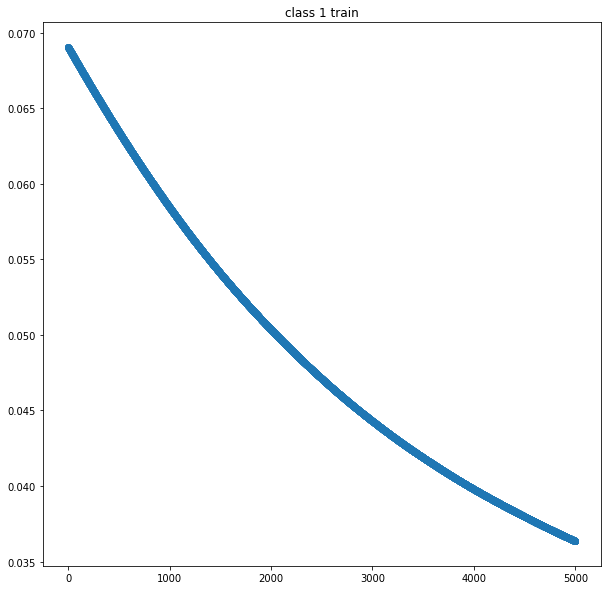

0.03635319322347641
4.0 -- 3.92393159866333
4.0 -- 3.562809944152832
4.0 -- 3.0581398010253906
4.0 -- 4.3185882568359375
2.0 -- 1.9316364526748657
1.0 -- 1.0718663930892944
4.0 -- 4.211127281188965
2.0 -- 2.1172752380371094
2.0 -- 2.2493553161621094
4.0 -- 4.741888046264648
1.0 -- 1.1426559686660767
2.0 -- 1.9122633934020996
1.0 -- 1.095723271369934
2.0 -- 1.9441494941711426
2.0 -- 2.2417829036712646
2.0 -- 2.2907915115356445
4.0 -- 4.017078399658203
1.0 -- 1.0389814376831055
2.0 -- 2.011592149734497
2.0 -- 2.126307249069214


In [74]:
classes = [1, 2, 4]
x_temp = []
y_temp = []
for class_ in classes:
    x_temp.extend(x_train[y_train==class_][:100])
    y_temp.extend(y_train[y_train==class_][:100])
x_temp, y_temp = unison_shuffle_copies(np.array(x_temp), np.array(y_temp))
x_temp = torch.tensor(x_temp, dtype=torch.float32, device=device)
y_temp = torch.tensor(y_temp, dtype=torch.float32, device=device)
loss_history = []
for epoch in range(5000):  # loop over the dataset multiple times
    running_loss = 0.0
    stime = time.time()
    
    # get the inputs; data is a list of [inputs, dist_true]
    model.train()
    inputs, dist_true = x_temp, y_temp
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = loss_fn(outputs, dist_true)
    
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

from utils import *
plot(loss_history, 'class 1 train')

model.eval()
op_temp = model(x_temp)
print(loss_history[-1])
for i,j in zip(y_temp[:20], op_temp.squeeze().tolist()[:20]):
    print(i.item(), '--', j)

#### Things to try
* Next try one cycle lr sched -- 
* Distance values of 2 & 3 dominate the data. Best way to handle?
* try batch normalization
* normalize outputs?
* try Mean Absolute Error (robust to large/small outliers) and Mean Sq log error.
* are features good enough for prediction? Check it. May be try XGBoost for it.
* stratified data
* check one-cycle LR and loss correlation. Log it in tensorboard.
* print out outputs to see why loss so high?
* next try run20 with step size 8--------
* try run23 without early stop
#### from [37 checklist]('https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607')
* try under sampling
* Make sure your batches don’t contain a single label -- batches skewed like this: [  58, 1795, 2514,  551,   78,    4], There are many batches where all are '1', e.g.:
114 -- (tensor([1.], device='cuda:0'), tensor([5000], device='cuda:0'))
115 -- (tensor([1.], device='cuda:0'), tensor([5000], device='cuda:0'))
* large batch can reduce the generalization ability of the model
* check model behaviour with random data and see if it's same
* try zero mean and unit variance
* train with just 1 or 2 examples and see if your network can learn to differentiate these. Then try more.
* checkout out gradients and activations: “A good standard deviation for the activations is on the order of 0.5 to 2.0. Significantly outside of this range may indicate vanishing or exploding activations.”, https://discuss.pytorch.org/t/how-can-i-get-the-gradients-of-the-weights-of-each-layer/28502
* 33. Visualize the training
* try leakyRelu
* try training with Mean relative error

#### Observations
* Tried overfitting with small number of sample to test if model learns. Here is the result:
  1. model worked for 5 samples of target 1. pred around ~1.2  (50 epochs)
  2. model didn't work for 5 samples of 1 & 2 each. all preds ~1.5(upto 1000 epochs tried)
  3. model worked for samples with target 2 only, all preds ~2 (50 epochs)
  4. model didn't work for 5 samples of 2 & 3 each. all preds ~2.5(upto 1000 epochs tried)
  5. model didn't work for 5 samples of 1 & 6 each. all preds ~3.5(upto 1000 epochs tried)
conclusion: model works for any single distance value at a time but not multiple (always tries to predict mid value of distances, e.g. for (1,5) prediction ~3), shuffling didn't help. May be need to <b>change loss function</b> or larger NN? -- larger NN made no difference, same model (2 hidden layers, lr=0.001) with poisson loss gives great result, even without data shuffling, epochs=1000.
* Next prob--> For same config adding 100 samples of 3 distances (1,2,4) significantly reduced performance.-- training for much longer (5K epochs) improved result significantly.
So, overSample minority targets and train for long time with poisson loss.
* Run 8 was succesfull but try to improve: reduce undersample, use small dropouts
* Run 10 was even better than run8. Better distance accuracies (avg 70.5), training became painfully slow after 1600 epochs so force stopped. May be try bette LR range next? 